In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import cv2
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from datetime import datetime
import scipy.io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.models as models
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!nvidia-smi

Sat Jun  6 10:31:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
my_transform = {
                'test': transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                        ])
                }

In [0]:
path_to_dataset = "/content/drive/My Drive/Colab Notebooks/project/test_dataset"
test_dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform = my_transform['test'])

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

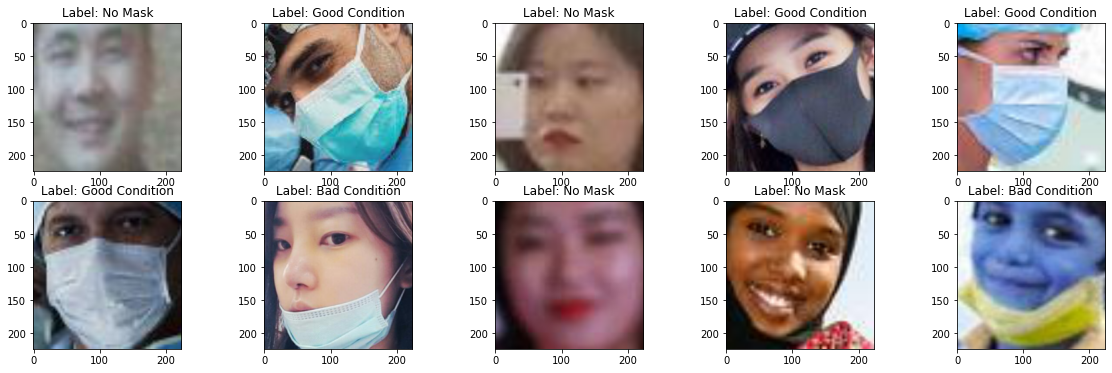

In [6]:
labels_dict = {0: 'Good Condition', 1: 'No Mask', 2: 'Bad Condition'}
scaler = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
inds = np.random.choice(len(test_dataset), 10, replace = False)
fig, axs = plt.subplots(2, 5, figsize = (20,6))
ax = axs.flatten()
for i, j in enumerate(inds):
  ax[i].imshow(scaler(test_dataset[j][0]).transpose(0,1).transpose(1,2))
  ax[i].set_title('Label: ' + labels_dict[test_dataset[j][1]])

In [0]:
# def get_class_distribution(dataset_obj):
#     count_dict = {v:0 for k,v in dataset_obj.dataset.class_to_idx.items()}
#     for element in dataset_obj:
#         y_lbl = element[1]
#         count_dict[y_lbl] += 1     
#     return count_dict

# print("Distribution of classes: \n", get_class_distribution(test_subset))

In [0]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=1,
                                           num_workers=4, pin_memory=True)

In [0]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, hidden_channels, kernel_size = 3, padding = 1, stride = 1):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(nn.Conv2d(in_channels, hidden_channels, kernel_size=kernel_size, padding= padding, stride=stride),
                                nn.ReLU(),
                               nn.MaxPool2d(2))
  def __call__(self, x):
    return self.block(x)

In [0]:
class MaskDetectionModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels = 3):
        super(MaskDetectionModel, self).__init__()
        self.block1 = ConvBlock(in_channels, hidden_channels)
        self.block2 = ConvBlock(hidden_channels, hidden_channels*2)
        self.block3 = ConvBlock(hidden_channels*2, hidden_channels*4)
        self.block4 = nn.Sequential(nn.Linear( hidden_channels*4 * 28*28, 1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, out_channels), 
                                    nn.Softmax(dim = 1))
        
        # Initialize layers' weights
        for sequential in [self.block1, self.block2, self.block3, self.block4]:
            for layer in sequential.children():
                if isinstance(layer, (nn.Linear, nn.Conv2d)):
                    nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.block4(out)
        return out

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        Flatten(),
        nn.Dropout(),
        nn.Linear(512 * 14 ** 2, 3),
        nn.BatchNorm1d(3),
        nn.ReLU(),
        nn.Linear(3, 3)
        # nn.Softmax(dim=1)
    )
    return model

In [0]:
model_names = ['Custom_model_1', 'vgg11_bn', 'Sequential9']

In [0]:
def create_instance(model_name, path = None, device='cuda'):
  # best_model_path =  'MultiLabel_' + model_name + '.best.pth'
  best_model_path = path + model_name + '.best.pth'
  # if path!=None:
  #   best_model_path = path + best_model_path

  if (model_name=='resnet_pretrained') or (model_name == 'resnet'):
    model = models.resnet18(pretrained=True)
    for layer, param in model.named_parameters():
      param.requires_grad = False
    model.fc = torch.nn.Sequential(nn.Linear(512, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 3),
                                    nn.Softmax(dim=1))
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()

  elif model_name == 'vgg11_bn':
    model = models.vgg11_bn(pretrained=True)
    model.classifier = torch.load(best_model_path)
    model.to(device)
    model.eval()
  
  elif model_name == 'mobilenet_v2':
    model = models.mobilenet_v2(pretrained=True)
    model.classifier = torch.nn.Sequential(
                                  torch.nn.Dropout(0.2),
                                  torch.nn.Linear(1280, 512),
                                  torch.nn.ReLU(),
                                  torch.nn.Dropout(0.2),
                                  torch.nn.Linear(512, 3)
                                  )
    model.classifier.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()

  elif model_name == 'custom':
    model = MaskDetectionModel(3, 32)
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    model.to(device)

  elif model_name == 'Custom_model_1':
    model = torch.load(best_model_path)['model']
    model.eval()
    model.to(device)

  elif model_name == 'Sequential9':
    model = torch.load(best_model_path)
    model.eval()
    model.to(device)

  elif model_name == 'resnet50':
    model = models.resnet50(pretrained=True)
    for layer, param in model.named_parameters():
      param.requires_grad = True
    model.fc = torch.nn.Sequential(nn.Linear(2048, 32),
                                   nn.BatchNorm1d(32),
                                    nn.ReLU(),
                                    nn.Linear(32, 3),
                                    nn.Softmax(dim=1))
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()

  return model

In [0]:
from tqdm.notebook import tqdm

In [0]:
def test_model_2(model_first, model_second, iterator, device='cuda'):
  target = []
  preds = []
  model.eval();
  with torch.no_grad():
    for X, y in iterator:
      out_first = model_first(X.to(device))
      label = out_first.argmax(dim=1)
      if label!=2:
          out_second = model_second(X.to(device))
          label = out_second.argmax(dim=1)
      target.append(y.item())
      preds.append(label) 
    acc = accuracy_score(np.array(target), np.array(preds))
    cm = confusion_matrix(np.array(target), np.array(preds),normalize='true')
  return acc, cm, target, preds

In [0]:
def test_model(model, iterator, device='cuda'):
    target = []
    preds = []
    model.eval();
    with torch.no_grad():
      for X, y in tqdm(test_batch_gen):
        out_first = model(X.to(device))
        # out_first = torch.nn.Softmax(dim=1)(out_first)
        label = out_first.argmax(dim=1)
        target.append(y.item())
        preds.append(label.item())
    acc = accuracy_score(np.array(target), np.array(preds))
    cm = confusion_matrix(np.array(target), np.array(preds), normalize='true')
    return acc, cm, target, preds

In [25]:
dict_with_results = dict()
dict_with_models = {}
for name in model_names:
  model = create_instance(name, '/content/drive/My Drive/Colab Notebooks/project/', device='cuda')
  acc, cm, target, preds = test_model(model, test_batch_gen, device='cuda')
  print('model:', name, 'accuracy:', acc)
  dict_with_results[name] = {'accuracy': acc, 'confusion_matrix': cm, 'target': target, 'preds': preds}
  dict_with_models[name] = model


model: Custom_model_1 accuracy: 0.7792494481236203



model: vgg11_bn accuracy: 0.8410596026490066



model: Sequential9 accuracy: 0.8344370860927153


In [0]:
acc, cm, target, preds = test_model_2(dict_with_models['Custom_model_1'], dict_with_models['vgg11_bn'],
                       test_batch_gen, device='cuda')
dict_with_results['Mixed_model'] = {'accuracy': acc, 'confusion_matrix': cm, 'target': target, 'preds': preds}

Text(0.5, 1.0, 'Model: Custom_model_1 + vgg11_bn\nAccuracy test: 84.106')

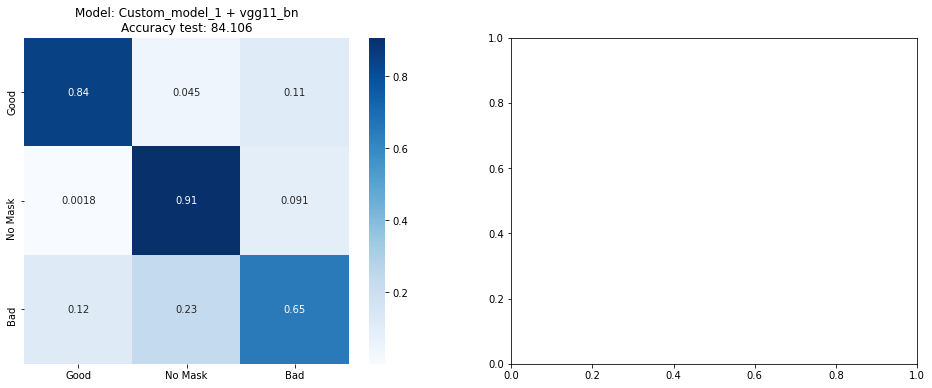

In [0]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
ax = axs.flatten()
i=0
df_cm = pd.DataFrame(cm, index = labels_dict.values(), columns = labels_dict.values())
sns.heatmap(df_cm, annot=True, ax = ax[i], cmap = 'Blues')
ax[i].set_title('Model: Mixed_model' + '\n' + 'Accuracy test: ' + np.round(acc*100, 4).astype(str))

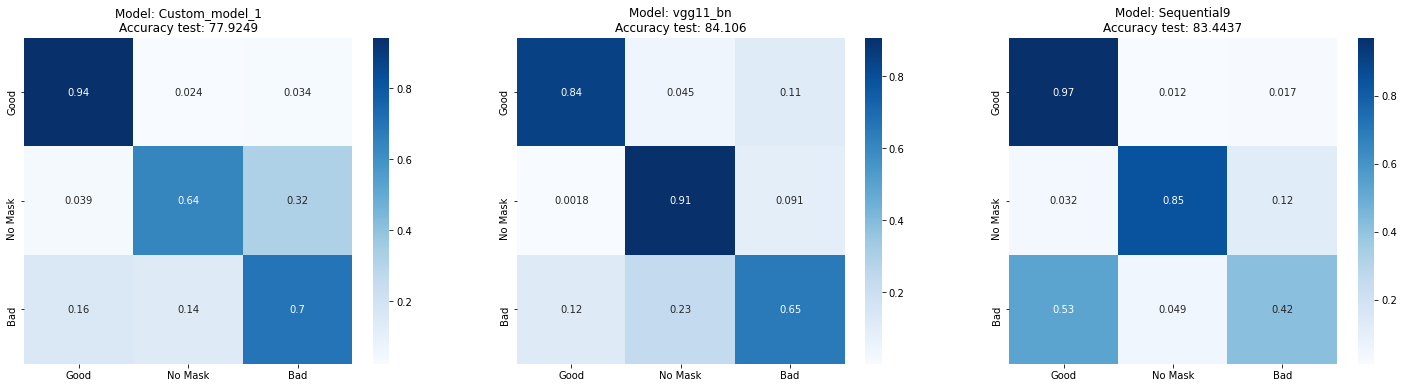

In [20]:
labels_dict = {0: 'Good', 1: 'No Mask', 2: 'Bad'}
fig, axs  = plt.subplots(1, 3, figsize = (25, 6))
ax = axs.flatten()
for i, name in enumerate(list(dict_with_results.keys())):
  acc, cm = dict_with_results[name]['accuracy'], dict_with_results[name]['confusion_matrix'] 
  df_cm = pd.DataFrame(cm, index = labels_dict.values(), columns = labels_dict.values())
  sns.heatmap(df_cm, annot=True, ax = ax[i], cmap = 'Blues')
  ax[i].set_title('Model: ' + name + '\n' + 'Accuracy test: ' + np.round(acc*100, 4).astype(str))

In [0]:
labels_dict = {0: 'Good Condition', 1: 'No Mask', 2: 'Bad Condition'}

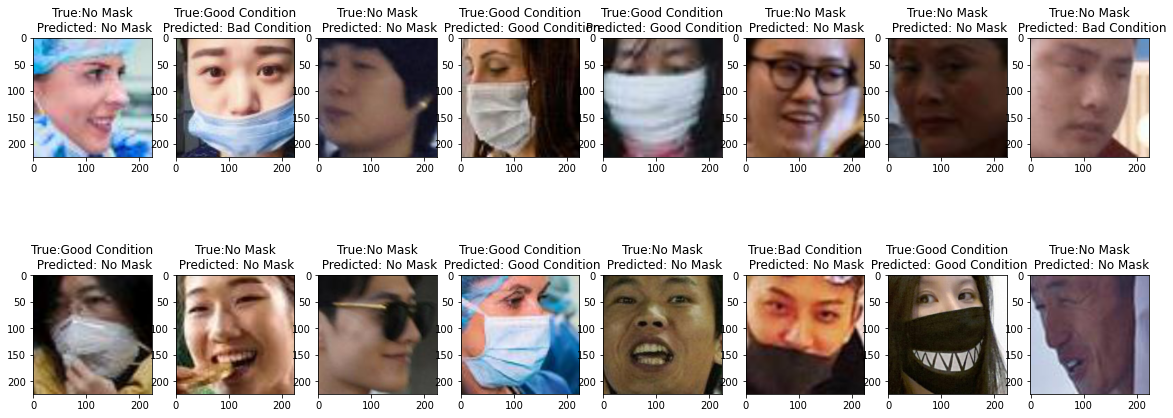

In [34]:
target, preds = dict_with_results['vgg11_bn']['target'], dict_with_results['vgg11_bn']['preds']

fig, axs = plt.subplots(2, 8, figsize = (20,8))
ax = axs.flatten()
# np.where(np.array(target) == np.array(preds))[0]
inds = np.random.choice(np.arange(len(test_dataset)), 16, replace=False)
for i, ind in enumerate(inds):
    unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    x = unorm(test_dataset[ind][0])
    ax[i].imshow(x.permute(1, 2, 0))
    ax[i].set_title('True:'  + labels_dict[test_dataset[ind][1]] + '\n Predicted: '  + labels_dict[preds[ind]])

In [0]:
import PIL

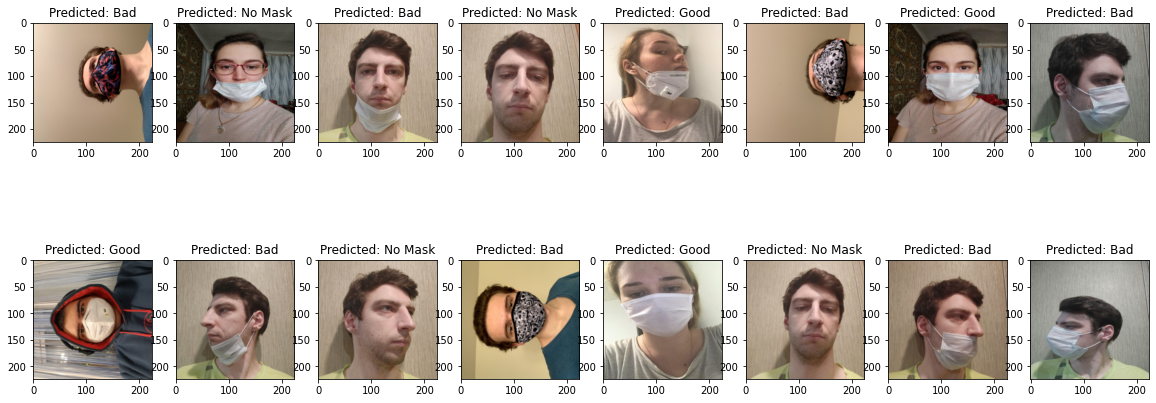

In [46]:
path_to_me = '/content/drive/My Drive/Colab Notebooks/project/custom_images'
my_pics = list(next(iter(os.walk(path_to_me)))[2])

inds = np.random.choice(np.arange(len(my_pics)), 16, replace=False)
model = dict_with_models['vgg11_bn']

fig, axs = plt.subplots(2, 8, figsize = (20, 8))
ax = axs.flatten()
labels_dict = {0: 'Good', 1: 'No Mask', 2: 'Bad'}
unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.eval();
with torch.no_grad():
  for i, j in enumerate(inds):
      picname = my_pics[j]
      im = PIL.Image.open(path_to_me + '/' + picname).convert('RGB')
      vals = my_transform['test'](im)
      out = model(vals[None].cuda())
      pred = (torch.nn.Softmax(dim=1)(out)).argmax(dim=1).item()
      ax[i-1].imshow(unorm(vals).permute(1, 2, 0))
      ax[i-1].set_title(f'Predicted: {labels_dict[pred]}')